In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_columns',None)

In [2]:
df = pd.read_csv('sales_train.csv')
df_sales = df.copy()
df_cat = pd.read_csv('items.csv')
df_test = pd.read_csv('test.csv')
#df_test = df_test.astype({'shop_id':'category','item_id':'category'})

In [3]:
df_sales = pd.merge(df_sales,df_cat[['item_id','item_category_id']], on = ['item_id'])

In [4]:
# I will drop the date columns, once, that we want to predict the sales in an month and we have some return that can introduce some error to the granularity of the day
df.drop(columns=['date'],inplace=True)
df_sales.drop(columns=['date'],inplace=True)

In [5]:
df = df.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().reset_index()
df_sales=df_sales.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].sum().reset_index()
df.columns=['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']
df_sales.columns =['date_block_num', 'shop_id', 'item_category_id', 'item_cnt_day']

In [6]:
df_sales.head()

,date_block_num,shop_id,item_category_id,item_cnt_day
0,0,0,2,53.0
1,0,0,3,28.0
2,0,0,4,16.0
3,0,0,5,28.0
4,0,0,6,65.0


In [7]:
df = pd.merge(df,df_cat[['item_id','item_category_id']], on = ['item_id'])
df.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id
0,0,0,32,6.0,40
1,0,1,32,7.0,40
2,0,3,32,3.0,40
3,0,4,32,2.0,40
4,0,6,32,8.0,40


In [8]:
df_aux_test = pd.merge(df_test,df_cat[['item_id','item_category_id']], on = 'item_id').drop(columns=['item_id'])
df_aux_test = df_aux_test.sort_values(by='ID', ascending=True)

In [9]:
pivot_table = pd.pivot_table(df_sales,columns=['date_block_num'], values=['item_cnt_day'], index=['shop_id','item_category_id'], fill_value=0, aggfunc='sum').reset_index()

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [10]:
pivot_table['sum'] = pivot_table.iloc[:, 23:].sum(axis=1)

In [11]:
# Shop's withou activity
check_close_shop = pivot_table.groupby('shop_id')['sum'].sum().reset_index()
check_close_shop.columns = ['shop_id','sales_12_months']

check_close_shop['close'] = 'active'
check_close_shop.loc[check_close_shop['sales_12_months']==0,'close'] = 'off'
check_close_shop = check_close_shop[check_close_shop['close']=='off']

#Check category discontinous 

check_close_cat = pivot_table.groupby('item_category_id')['sum'].sum().reset_index()
check_close_cat.columns = ['item_category_id','sales_12_months']

check_close_cat['close'] = 'active'
check_close_cat.loc[check_close_cat['sales_12_months']==0,'close'] = 'off'
check_close_cat = check_close_cat[check_close_cat['close']=='off']


In [12]:
df_aux_test = df_aux_test[(df_aux_test.item_category_id.isin(check_close_cat.item_category_id)) | (df_aux_test.shop_id.isin(check_close_shop.shop_id))]
df_aux_test['pred'] = 0
submission_01 = df_aux_test[['ID','pred']]

In [13]:
df_test = df_test[~(df_test.ID.isin(submission_01.ID))]

In [14]:
df_test =  pd.merge(df_test,df_cat[['item_id','item_category_id']], on = ['item_id'])
df_test.head()

,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,5100,4,5037,19
2,10200,6,5037,19
3,15300,3,5037,19
4,20400,2,5037,19


In [15]:
pivot_table = pd.pivot_table(df,columns=['date_block_num'], values=['item_cnt_day'], index=['shop_id','item_id','item_category_id'], fill_value=0, aggfunc='sum').reset_index()
data = pd.merge(df_test,pivot_table,on = ['item_id','shop_id','item_category_id'],how = 'left').fillna(0)

In [16]:
data.head()

,ID,shop_id,item_id,item_category_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5100,4,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,10200,6,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,3.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0
3,15300,3,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0,4.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0
4,20400,2,5037,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0


In [17]:
data['sum'] = data.iloc[:,24:].sum(axis=1)

data['sum_cat']= data.groupby('item_category_id')['sum'].transform('sum')

data['sum_item']= data.groupby('item_id')['sum'].transform('sum')

In [18]:
def check_number_cluster(X):
    wscc = []
    
    for i in range(1,10):
        kmeans = KMeans(n_clusters=i, init='k-means++',max_iter = 300,n_init = 10, random_state=42)
        kmeans.fit(X)
        wscc.append(kmeans.inertia_)
    return wscc

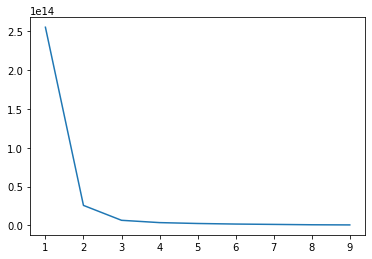

In [19]:
wscc = check_number_cluster(data[['sum_cat']])
plt.plot(range(1,10),wscc)

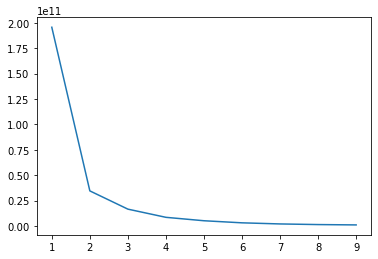

In [20]:
wscc = check_number_cluster(data[['sum_item']])
plt.plot(range(1,10),wscc)

In [21]:
def _cluster_data(df,name):
    if name == 'sum_cat':
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(df[[name]])
        name_cluster= name+'Cluster'
        df[name_cluster]= kmeans.predict(df[[name]])
        return df
    else:
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(df[[name]])
        name_cluster= name+'Cluster'
        df[name_cluster]= kmeans.predict(df[[name]])
        return df

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [22]:
"""in order to have shop diveded by class's , like 'champion shop', 'High shop', 'Medium shop' and 'Low shop' 
i decide to make a cluster by number of sales by shop"""

data=_cluster_data(data,'sum_cat')
data = order_cluster('sum_catCluster', 'sum_cat',data,True)

data=_cluster_data(data,'sum_item')
data = order_cluster('sum_itemCluster', 'sum_item',data,True)

In [23]:
data.groupby('sum_itemCluster')['sum_item'].agg(['mean','count'])

,mean,count
sum_itemCluster,,
0,90.492955,202692
1,1065.035156,10752
2,5074.250000,672
3,62078.000000,42


In [24]:
data.groupby('sum_catCluster')['sum_cat'].agg(['mean','count'])

,mean,count
sum_catCluster,,
0,8130.648049,109788
1,36264.483745,32298
2,83711.790210,72072


In [25]:
data['item_id'] = data['sum_itemCluster']
data['item_category_id'] = data['sum_catCluster']

data.drop(columns=['sum','sum_cat','sum_item','sum_catCluster','sum_itemCluster'], inplace=True)

In [26]:
def model_selection(X_train,y_train):

    n_estimators=[50,100,150,200]
    max_features=['auto', 'sqrt', 'log2']
    max_depth = [5,10,20,30,40,50]
    max_depth.append(None)
    min_samples_split = [2,5,10,15,20]
    min_samples_leaf = [1,2,5,10,15]

    grid_param = {'n_estimators':n_estimators,
                  'max_features':max_features,
                  'max_depth':max_depth,
                  'min_samples_split':min_samples_split,
                  'min_samples_leaf':min_samples_leaf}

    RF_model = RandomForestRegressor()
    RF_model_random = RandomizedSearchCV(estimator = RF_model,
                                    param_distributions = grid_param, n_iter=5,
                                    cv=5, verbose=2, random_state=42,
                                    n_jobs=-1)

    RF_model_optimized= RF_model_random.fit(X_train,y_train)

    model = RF_model_optimized.best_estimator_
    _ = model.fit(X_train,y_train)
    return model

In [27]:
#Select, train and made predictions 

X_train = data.iloc[:,2:-1]
y_train = data.iloc[:,-1]

model = model_selection(X_train,y_train)

X_teste = data.drop(columns=[('item_cnt_day', 0)])
#data['pred']= model.predict(X_teste.iloc[:,2:])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [33]:
y_pred = pd.Series(model.predict(X_train))

In [36]:
erro = y_train - y_pred

In [47]:
rf_model_erro = model_selection(X_train,erro)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [48]:
data['pred_aux']= pd.Series(model.predict(X_teste.iloc[:,2:]))
data['err_aux'] = pd.Series(rf_model_erro.predict(X_teste.iloc[:,2:]))
data['pred'] = data['pred_aux']-data['err_aux']

In [49]:
submission_02 = data[['ID','pred']]

In [50]:
submission = pd.concat([submission_01,submission_02],ignore_index=False)
submission = submission.sort_values(by=['ID'],ascending=True)
submission=submission.rename(columns={'pred':'item_cnt_month'})

In [54]:
submission.head()

,ID,item_cnt_month
0,0,0.532375
39942,1,0.175809
10752,2,0.633716
10794,3,0.172105
39984,4,0.175809


In [52]:
submission.to_csv('submission.csv',index=False)